In [14]:
import cv2 
import os 
import numpy as np 
import optuna 
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay 
import matplotlib.pyplot as plt
from tqdm import tqdm 
from skimage import feature 
import json 
import joblib

In [2]:
DATASET_PATH = 'dataset_augmented'
IMG_WIDTH = 224
IMG_HEIGHT = 224
N_TRIALS = 100
N_FOLDS = 5

In [3]:
def load_and_extract_hog(path, label):
    data = []
    labels = []
    files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for f in tqdm(files, desc=f"Loading label {label}"):
        img_path = os.path.join(path, f)
        image = cv2.imread(img_path)
        if image is None: continue
        
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        hog_feat = feature.hog(
            gray, 
            orientations=9, 
            pixels_per_cell=(16, 16), 
            cells_per_block=(2, 2), 
            transform_sqrt=True, 
            block_norm='L1'
        )
        
        data.append(hog_feat)
        labels.append(label)
        
    return data, labels

In [5]:
pos_X, pos_y = load_and_extract_hog(os.path.join(DATASET_PATH, 'Positive'), 1)
neg_X, neg_y = load_and_extract_hog(os.path.join(DATASET_PATH, 'Negative'), 0)
X = np.array(pos_X + neg_X)
y = np.array(pos_y + neg_y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Tuning on Training Set: {X_train.shape}")
print(f"Held-out Test Set: {X_test.shape} (Untouched)")

Loading label 0: 100%|██████████| 1325/1325 [01:14<00:00, 17.89it/s]

Tuning on Training Set: (1987, 6084)
Held-out Test Set: (663, 6084) (Untouched)


In [6]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1 
    )
    
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro')
    
    return scores.mean()

In [9]:
print(f"\n--- STARTING TUNING ({N_TRIALS} Trials) ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

print("\n" + "="*40)
print("OPTUNA TUNING COMPLETE")
print("="*40)
print(f"Best Trial Score (Macro F1): {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-12-05 23:42:16,362] A new study created in memory with name: no-name-d370227f-c15b-42bd-ad23-d98cf9d317da



--- STARTING TUNING (100 Trials) ---


[I 2025-12-05 23:42:19,942] Trial 0 finished with value: 0.7767660476359864 and parameters: {'n_estimators': 141, 'max_depth': 47, 'min_samples_split': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.7767660476359864.
[I 2025-12-05 23:42:27,216] Trial 1 finished with value: 0.775169167847969 and parameters: {'n_estimators': 293, 'max_depth': 46, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.7767660476359864.
[I 2025-12-05 23:42:34,892] Trial 2 finished with value: 0.7802139204003579 and parameters: {'n_estimators': 260, 'max_depth': 27, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7802139204003579.
[I 2025-12-05 23:42:38,173] Trial 3 finished with value: 0.7806315935694216 and parameters: {'n_estimators': 114, 'max_depth': 21, 'min_samples_split': 16, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.7806315935694216.
[I 2025-12-05 23:42:40,559] Trial 4 finished with value: 0.7748830289321359 and parameters


OPTUNA TUNING COMPLETE
Best Trial Score (Macro F1): 0.7974
Best Parameters:
  n_estimators: 144
  max_depth: 17
  min_samples_split: 6
  min_samples_leaf: 1


# Show Metrics


--- Training Final Champion Model ---

--- Generating Final Evaluation ---

Classification Report:
              precision    recall  f1-score   support

No Crack (0)       0.78      0.76      0.77       332
   Crack (1)       0.76      0.79      0.77       331

    accuracy                           0.77       663
   macro avg       0.77      0.77      0.77       663
weighted avg       0.77      0.77      0.77       663

Confusion Matrix:
 [[252  80]
 [ 71 260]]


<Figure size 800x600 with 0 Axes>

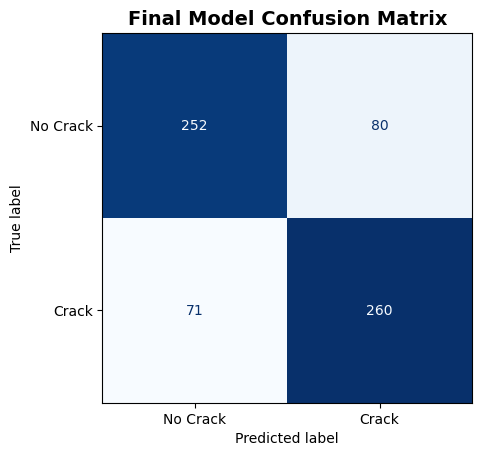


Final Matrix saved as 'final_confusion_matrix.png'


In [13]:
print("\n--- Training Final Champion Model ---")

model = RandomForestClassifier(
    n_estimators=144,
    max_depth=17,
    min_samples_split=6,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

print("\n--- Generating Final Evaluation ---")
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Crack (0)', 'Crack (1)']))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Crack', 'Crack'])

disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title('Final Model Confusion Matrix', fontsize=14, fontweight='bold')
plt.savefig('./Result/final_confusion_matrix.png', dpi=300)
plt.show()

print("\nFinal Matrix saved as 'final_confusion_matrix.png'")

# Save Result

In [10]:
optuna_results = {
    "best_score": study.best_value,
    "best_params": study.best_params,
    "n_trials": N_TRIALS,
    "feature_type": "HOG 16x16"
}

filename = './Result/optuna_results.json'
print(f"\nSaving best parameters to '{filename}'...")

with open(filename, 'w') as f:
    json.dump(optuna_results, f, indent=4)
    
print('Saved Successfully!')


Saving best parameters to './Result/optuna_results.json'...
Saved Successfully!


In [15]:
print('SAVING CHECKPOINT')

model_filename = './Result/final_crack_detector_rf.pkl'
joblib.dump(model, model_filename)
print(f'Model saved to: {model_filename}')

np.save('./Result/features_X.npy', X)
np.save('./Result/labels_y.npy', y)
print('features saved')

print('checkpoint saved')

SAVING CHECKPOINT
Model saved to: ./Result/final_crack_detector_rf.pkl
features saved
checkpoint saved
